In [ ]:
wd<-"/home/jovyan/zxli_SCI/result/Seurat/sc_Astrocyte_recluster/lee/classifyBySpatialMarker/"
if(!dir.exists(wd))
    dir.create(wd)
setwd(wd)
getwd()

In [3]:
source("/home/jovyan/zxli_SCI/script/self_function/pheatmap_add_flag.R")

In [4]:
source("/home/jovyan/zxli_SCI/script/self_function/save_pheatmap_pdf.R")

In [ ]:
library(Matrix)
#library(doParallel)
library(Seurat)
library(ggplot2)
library(patchwork)
library(dplyr)
#library(hdf5r)
library(png)
#library(ggalluvial)
#library(tidyverse)
library(clustree)
library(RCTD)
library(Matrix)
#library(SPOTlight)
library(future)
library(grid)
#library(RColorBrewer)
library(pheatmap)
#library(circlize)
library(igraph)
#library(ComplexHeatmap)
library(stringr)
#library(ComplexHeatmap)
library(cowplot)
library(scales)
#library(dplyr)
#library(tidyverse)
library(reshape2)
library(ComplexHeatmap)
library(RColorBrewer)
library(biomaRt)
#library(scClustViz)
library(scales)
library(colorspace)
library(clusterProfiler)
options(connectionObserver = NULL)
library("readxl")

### hclust 317 astrocyte deconvolution marker in spot level

In [2673]:
#load normalized spot expression data
#ma<-readRDS("/home/jovyan/zxli_SCI/result/cellchat/WT.SCT.data.rds")
#ma<-readRDS("/home/jovyan/zxli_SCI/result/Seurat/Astr_spot_relcuster/astr_pre.subtype_shamdomain.wxtest.63markers.prop0.SCT.data.meta.rds")
ma<-readRDS("/home/jovyan/zxli_SCI/result/Seurat/Astr_spot_relcuster/astr.prop0.317markers.SCTscale.data.meta.rds")

In [ ]:
# subset sample and Astrocyte_gfap
meta<-ma@meta.data
meta_sub<-subset(meta,sample %in% c('WT_sham_H_R2_1mm_2','WT_sham_H_R2_4','WT_sham_T_210323_4','WT_sham_T_R2_1mm_4',
                                                  'WT_3h_H_R2_1mm_2','WT_3h_H_R2_2','WT_3h_T_R2_1','WT_3h_T_210330_1mm_3',
                                                  'WT_24h_H_R1_1mm_3','WT_24h_H_R1_4','WT_24h_T_201231_3','WT_24h_T_R1_1mm_3',
                                                  'WT_72h_H_R1_1mm_2','WT_72h_H_210323_1','WT_72h_T_R2_4','WT_72h_T_R1_1mm_3')& Astr_state2=="Astr_Gfap")
dim(meta_sub)
cells<-rownames(meta_sub)

In [ ]:
exp<-as.matrix(ma@assays$RNA@counts[,cells])
dim(exp)

In [ ]:
astr_marker<-rownames(exp)
length(astr_marker)

In [ ]:
exp_bi<-ifelse(exp>0,1,-1)
table(exp_bi)

In [ ]:
colnames(meta_sub)
meta_sub$domain2<-ifelse(meta_sub$domain_res02=="WM","WM","GM")

In [2718]:
### time_distance_domain bulk
sp_df<-data.frame()
for(i in unique(meta_sub$orig.ident)){
    if(grepl("sham",i) | grepl("3h",i)){
        temp_me<-meta_sub[meta_sub$Astr_state%in%c("WM_Astr_Gfap"#,"MG_Astr_Slc"
                                                  )&
                            meta_sub$orig.ident==i,]
        #table(temp_me$Astr_state)
    
        temp_ma<-as.data.frame(t(exp_bi[,rownames(temp_me)]))
        temp_ma$group<-temp_me$domain_res02
        temp_mean<-temp_ma %>% group_by(group) %>% summarise_all("mean")
        temp_mean$section<-i
        temp_mean<-as.data.frame(temp_mean)
    }
    if(grepl("24",i) | grepl("72h",i)){
        temp_me<-meta_sub[meta_sub$Astr_state%in%c("WM_Astr_Gfap",#"MG_Astr_Slc",
                                           "MG_Astr_Gfap")
                           & meta_sub$orig.ident==i,]
        table(temp_me$Astr_state)
    
        temp_ma<-as.data.frame(t(exp_bi[,rownames(temp_me)]))
        temp_ma$group<-temp_me$domain_res02
        temp_mean<-temp_ma %>% group_by(group) %>% summarise_all("mean")
        temp_mean$section<-i
        temp_mean<-as.data.frame(temp_mean)
    }
    sp_df<-rbind(sp_df,temp_mean)
    
}


In [ ]:
dim(sp_df)
sp_df$key<-paste0(sp_df$section,"_",sp_df$group)
unique(sp_df$key)
sp_df$section<-factor(sp_df$section,levels = c('WT_sham_H_R2_1mm','WT_sham_H_R2','WT_sham_T_210323','WT_sham_T_R2_1mm',
                                              'WT_3h_H_R2_1mm','WT_3h_H_R2','WT_3h_T_R2','WT_3h_T_210330_1mm',
                                              'WT_24h_H_R1_1mm','WT_24h_H_R1','WT_24h_T_201231','WT_24h_T_R1_1mm',
                                              'WT_72h_H_R1_1mm','WT_72h_H_210323','WT_72h_T_R2','WT_72h_T_R1_1mm'))

sp_df$time<-NA
sp_df$time[grepl("sham",sp_df$section)]<-"sham"
sp_df$time[grepl("3h",sp_df$section)]<-"3h"
sp_df$time[grepl("24h",sp_df$section)]<-"24h"
sp_df$time[grepl("72h",sp_df$section)]<-"72h"
table(sp_df$time)
sp_df$RC<-NA
sp_df$RC[grepl("_H_",sp_df$section)]<-"rostral"
sp_df$RC[grepl("_T_",sp_df$section)]<-"caudal"
table(sp_df$RC)
sp_df$distance<-NA
sp_df$distance<-ifelse(grepl("_1mm",sp_df$section),"1mm","0.5mm")
table(sp_df$distance)
sp_df$domain<-sp_df$group
sp_df$time<-factor(sp_df$time,levels = c("sham","3h","24h","72h"))
sp_df$RC<-factor(sp_df$RC,levels = c("rostral","caudal"))
sp_df$distance<-factor(sp_df$distance,levels = c("0.5mm","1mm"))
sp_df$domain<-factor(sp_df$domain,levels = c("WM","MG")#c("WM","MG","DH","VH")
                    )

In [2720]:
write.csv(sp_df,"astr_gfap.317marker.scale.express.binary.mean.in.time_Ct2domain.meta.csv")

In [ ]:
### just look into WM and MG
sp_df_sub<-sp_df[sp_df$domain%in%c("WM","MG"),]
dim(sp_df_sub)

In [ ]:
ha1_s<-columnAnnotation(time=sp_df_sub$time,
                       RC=sp_df_sub$RC,
                       distance=sp_df_sub$distance,
                       domain=sp_df_sub$domain,
                     col=list(time=structure(names=c("sham","3h","24h","72h"),c("#374E55FF","#DF8F44FF","#00A1D5FF","#B24745FF")),
                             RC=structure(names=c("rostral","caudal"),c('#F4A582','#0571B0')),
                             distance=structure(names=c("1mm","0.5mm"),c('#63A79C','#FB9A99')),
                             domain=structure(names=c("WM","MG"),c("#20854EA8","#0072B5A8"))))                     

In [ ]:
##options(repr.plot.width=10,repr.plot.height=13)
###pdf("317.markers.time_domain.onlyWM_MG.clustered.km4.heatmap.pdf",width = 10,height = 14)
p<-Heatmap(t(sp_df_sub[,astr_mark]),cluster_columns = T,show_row_names = F,km = 4,
        col = c("#05445E","#92a8d1","#F6E6E8","#E56997","#B91646"),#colorRampPalette(colors = c("#80ced6","#d5f4e6","#f7cac9","#c94c4c"))(50),#row_names_max_width = unit(2,"cm"),
        cluster_rows = T,
        #clustering_distance_rows = "pearson",
        show_column_names = F,
        #left_annotation = ha,
        top_annotation = ha1_s#,show_column_names = F
       )
###dev.off()

In [ ]:
## get the cluster annotation dataframe
r.dend<-row_dend(p)
rcl.list<-row_order(p)
lapply(rcl.list,function(x) length(x)) #check/confirm size of clusters
#loop to extract genes for each cluster
for(i in 1:length(rcl.list)){
    if(i==1){
        clu<-t(t(astr_mark[rcl.list[[i]]]))
        out<-cbind(clu,names(rcl.list)[i])
        colnames(out)<-c("gene","Cluster")
    } else {
        clu<-t(t(astr_mark[rcl.list[[i]]]))
        clu<-cbind(clu,names(rcl.list)[i])
        out<-rbind(out,clu)
    }
}
out<-as.data.frame(out)
head(out)
table(out$Cluster)

In [2729]:
rownames(out)<-out$gene

In [ ]:
out[out$Cluster==3,"gene"]
out[out$Cluster==4,"gene"]

In [2733]:
write.csv(out,"gfap.astr.317marker.scaled.express.binary.mean.in.time_ct2domain.heatmap.km4.geneclusters.csv")

In [4]:
out<-read.csv("gfap.astr.317marker.scaled.express.binary.mean.in.time_ct2domain.heatmap.km4.geneclusters.csv")

In [ ]:
out[out$gene=="Gfap",]
out[out$gene=="Slc7a10",]

In [ ]:
c1<-out[out$Cluster==1,"gene"]
c1
c2<-out[out$Cluster==2,"gene"]
c2
c3<-out[out$Cluster==3,"gene"]
c3
c4<-out[out$Cluster==4,"gene"]
c4
#c5<-out[out$Cluster==5,"gene"]
#c5
#c6<-out[out$Cluster==6,"gene"]
#c6
#c7<-out[out$Cluster==7,"gene"]
#c7
#c8<-out[out$Cluster==8,"gene"]
#c8

In [ ]:
da<-readRDS("/home/jovyan/zxli_SCI/result/Seurat/sc_Astrocyte_recluster/lee/Astrocyte.Gfap.pc16.res02.rds")
#da<-readRDS("gfap.317_bi_m13.hclust2.cluster.rds")
da

### calculate the genelist score in single cell Gfap astrocyte

In [59]:
da<-AddModuleScore(da,
                     features = list(c1,c2,c3,c4#,c5,c6,c7,c8
                                    ),
                     name = c("module1","module2","module3","module4"#,"module5","module6","module7","module8"
                             ))

In [ ]:
options(repr.plot.width=10,repr.plot.height=10)
FeaturePlot(da,pt.size = 1.5,ncol = 2,
            features = c('module11',"module22","module33",'module44'#,"module55","module66","module77","module88"
                                ),
            #keep.scale = NULL,
            #cols =c("#3BC3C4","#F2D4CE","#CA3566"),
            cols= c(#"#cfe0e8",
    
                                                     # '#b8a9c9', 
    '#d6d4e0',
    "#f0f0f0",
    '#fff2df',
    "#eeac99",#"#ED797B",
                     "#c83349")
            #max.cutoff="q10",
            #min.cutoff="q1"
            
           )
##ggsave("sc.seuratUMAP.module1.4.png",width = 12,height = 5,dpi = 300)

#### hclust and kmeans based on two genelist score dimension

In [348]:
set.seed(220609)
hc2<-cutree(hclust(dist(da@meta.data[,c('module33',#"module22","module33",
                                        'module11'#,"module55","module66","module77","module88"
                                       )],
                        method = "maximum")),
            k = 2)

In [ ]:
options(repr.plot.width=5,repr.plot.height=5)
ggplot(da@meta.data,aes(x=module33,y=module11,col=as.factor(hc2)))+
    #scale_color_manual(values = )+
    geom_point()+
    theme_classic()+
     scale_color_manual(values = c('#911eb4',"#ff7b25"))#+
    #geom_vline(xintercept = 0)+
    #geom_hline(yintercept = 0)
ggsave("sc.Astrocyte_Gfap.hclust2.bySpatialM13Score.scaterplot.png",width = 5,height = 5,dpi = 300)

In [242]:
da$Nxrn1<-da@assays$SCT@data["Nrxn1",]
da$scale_Nxrn1<-da@assays$SCT@scale.data["Nrxn1",]

In [ ]:
options(repr.plot.width=5,repr.plot.height=5)
ggplot(da@meta.data,aes(x=module33,y=module11,col=scale_Nxrn1))+
    #scale_color_manual(values = )+
    geom_point()+
    theme_classic()+
     scale_color_gradientn(colours = c(c(#"#cfe0e8",
    
                                                     # '#b8a9c9', 
    '#d6d4e0',
    "#f0f0f0",
    '#fff2df',
    "#eeac99",#"#ED797B",
                     "#c83349")))#+
    #geom_vline(xintercept = 0)+
    #geom_hline(yintercept = 0)

In [250]:
da$hcluster<-as.factor(hc2)
#da$kcluster<-as.factor(kc2$cluster)

In [ ]:
options(repr.plot.width=5,repr.plot.height=5)
ggplot(da@meta.data,aes(x=module33,y=module11,col=Gfap))+
    scale_color_gradientn(colours = c(#"#cfe0e8",
    
                                                     # '#b8a9c9', 
    '#d6d4e0',
    "#f0f0f0",
    '#fff2df',
    "#eeac99",#"#ED797B",
                     "#c83349"))+
    geom_point()+
    theme_classic()#+
    #geom_vline(xintercept = 0)+
    #geom_hline(yintercept = 0)

In [ ]:
options(repr.plot.width=5,repr.plot.height=5)
ggplot(da@meta.data,aes(x=module33,y=module11,col=Slc7a10))+
    scale_color_gradientn(colours = c(#"#cfe0e8",
    
                                                     # '#b8a9c9', 
    '#d6d4e0',
    "#f0f0f0",
    '#fff2df',
    "#eeac99",#"#ED797B",
                     "#c83349"))+
    geom_point()+
    theme_classic()#+
    #geom_vline(xintercept = 0)+
    #geom_hline(yintercept = 0)

In [ ]:
Idents(da)<-da$hcluster
options(repr.plot.width=5,repr.plot.height=5)
VlnPlot(da,features = c("Gfap","Slc7a10"),cols = c('#911eb4',"#ff7b25"),slot = "data",pt.size = 0)
ggsave("sc.Astrocyte_Gfap.hclust2.bySpatialM13Score.Gfap_Slc7a10.data.Vlnplot.png",width = 5,height = 5,dpi = 300)

In [4]:
test1<-da#subset(da,subset = facs%in%c("dp","g","s"))
Idents(test1)<-test1$hcluster

In [ ]:
mark<-FindAllMarkers(test1,logfc.threshold = 0.5,only.pos = T,return.thresh = 0.01)

In [ ]:
table(mark$cluster)
table(mark$pct.1>0.5&mark$avg_log2FC>1)
mark_s<-mark[mark$pct.1>0.5&mark$avg_log2FC>1,]
table(mark_s$cluster)

In [226]:
write.csv(mark_s,"gfap.317marker.k4.m13.hclust2.fc1.pct05.pad001.pos.markers.csv")

In [ ]:
mark
write.csv(mark,"gfap.317marker.k4.m13.hclust2.fc05.pad001.pos.markers.csv")

In [ ]:
genes<-mark[,#mark$cluster==2,
            "gene"]
length(genes)

In [ ]:
options(repr.plot.width=8,repr.plot.height=10)
mark %>% #subset(mark$gene %in% genes) %>% group_by(cluster)-> top10
    group_by(cluster) %>%
    top_n(n = 40, wt = avg_log2FC) ->top10

DoHeatmap(test1, features = top10$gene) +
    scale_fill_gradientn(colours = c('#4575B4','#91BFDB','#E0F3F8','white','#FC8D59','#D73027'))#+ NoLegend()
#ggsave("top25.2gfap_clustersmakrer.heatmap.png",width = 5,height = 8,dpi = 300)

In [ ]:
all_m<-unique(genes)
length(all_m)#c(m1,m2,m3)

In [ ]:
#g1<-spatial_marker[spatial_marker$group=="WM_Gfap","gene"]#c3#c1
#g2<-spatial_marker[spatial_marker$group=="MG_Slc7a10","gene"]#c4#c4
p_genes<-intersect(c(c1,c3),all_m)
p_genes

In [ ]:
bulk_exp<-test1@assays$SCT@scale.data[all_m,]
#bulk_exp<-t(scale(t(bulk_exp)))
dim(bulk_exp)

In [ ]:
head(bulk_exp)
df<-as.data.frame(t(bulk_exp))
df$cluster<-as.character(test1$hcluster)
df_mean<-aggregate(df[,colnames(df)!="cluster"],list(df$cluster),mean)
head(df_mean)

In [ ]:
rownames(df_mean)<-df_mean[,1]
df_mean<-df_mean[,-1]
head(df_mean)
row_col<-data.frame(row.names = colnames(df_mean))
row_col$color<-"grey"
row_col[p_genes,"color"]<-"#ff7b25"#"#911eb4"
#row_col[intersect(g2,rownames(row_col)),"color"]<-"#e6beff"
table(row_col$color)

In [ ]:
temp<-as.matrix(t(df_mean))
options(repr.plot.width=5,repr.plot.height=10)
p<-pheatmap::pheatmap(temp,show_rownames = T,cluster_cols = T,scale = "none",
                      clustering_distance_rows = "euclidean",
                      clustering_method = "average",#labels_row = lab_row,
                   cellwidth = 20,
                   cellheight = 1,
                   fontsize = 8,
                   #na_col = NULL,
                   border_color = NA
                   #,scale = "none",col = viridis_pal()(50)
       )
cols<-row_col[order(match(rownames(temp),p$gtable$grobs[[5]]$label)),]
p$gtable$grobs[[5]]$gp=gpar(col=cols)
add.flag(p,kept.labels = p_genes,repel.degree = 1)

In [ ]:
pdf("gfap.m13.hclust2.cluster.fc05.pad001.marker.bulk.pheatmap.pdf",width = 5,height = 10)
add.flag(p,kept.labels = p_genes,repel.degree = 1)
dev.off()
#save_pheatmap_pdf(p2,"b_strategy.hclust.3.cluster.marker.bulk.pheatmap.pdf")

In [2841]:
saveRDS(test1,"gfap.317_bi_m13.hclust2.cluster.rds")

In [218]:
test1<-readRDS("gfap.317_bi_m13.hclust2.cluster.rds")

In [9]:
write.csv(test1@meta.data,"gfap.317_bi_m13.hclust2.cluster.metadata.csv")

### look at all astrocyte state -220617

In [ ]:
da<-readRDS("/home/jovyan/zxli_SCI/result/Seurat/sc_Astrocyte_recluster/lee/L2.Astrocyte.nC2500.rmMt_Rp.SCTregICMR.doscale.pc16.res035.k40_gfaphclust.all.rds")
da

In [ ]:
Idents(da)<-da$SCT_snn_res.0.35
da$Gfap<-da@assays$SCT@data["Gfap",]
da$Slc7a10<-da@assays$SCT@data["Slc7a10",]
da$scale_Gfap<-da@assays$SCT@scale.data["Gfap",]
da$scale_Slc7a10<-da@assays$SCT@scale.data["Slc7a10",]
da<-AddModuleScore(da,
                     features = list(c1,c2,c3,c4#,c5,c6,c7,c8
                                    ),
                     name = c("module1","module2","module3","module4"#,"module5","module6","module7","module8"
                             ))
da<-AddModuleScore(da,
                     features = list(deg_dp
                                    ),
                     name = c("deg_dp"#,"module5","module6","module7","module8"
                             ))

options(repr.plot.width=10,repr.plot.height=4)
VlnPlot(da,features = c("module11","module22","module33","module44"),ncol = 4)


In [ ]:
da$m13_score<-sqrt((da$module11-min(da$module11))^2+(da$module33-min(da$module33))^2)
options(repr.plot.width=6,repr.plot.height=5)
ggplot(da@meta.data,aes(x=module33,y=module11,col=da$m13_score))+
    scale_color_manual(values = c('#911eb4','#ff7b25'))+
    geom_point()+
    theme_classic()+
    scale_color_gradientn(colours = c(#"#cfe0e8",
    
                                                     # '#b8a9c9', 
    '#d6d4e0',
    "#f0f0f0",
    '#fff2df',
    "#eeac99",#"#ED797B",
                     "#c83349"))

### find DEG between gfap_wm, gfap_gm and Slc7a10 -220615

In [77]:
da1<-da

In [ ]:
da1$state<-"GM_Slc7a10"
da1$state[da1$gfap_hclust==1]<-"WM_Gfap"
da1$state[da1$gfap_hclust==2]<-"GM_Gfap"
table(da1$state)

#### extract normalized data to do scenic analysis

In [ ]:
meta<-da1@meta.data
write.csv(meta,"L2.Astrocyte.nC2500.rmMt_Rp.SCTregICMR.doscale.pc16.res035.k40_gfaphclust.all.metadata.csv")
norm_ma<-da1@assays$SCT@data
dim(norm_ma)
saveRDS(norm_ma,"L2.Astrocyte.nC2500.rmMt_Rp.SCTregICMR.doscale.pc16.res035.k40.SCT.normalized.data.rds")

In [452]:
write.csv(norm_ma,"L2.Astrocyte.nC2500.rmMt_Rp.SCTregICMR.doscale.pc16.res035.k40.SCT.normalized.data.csv")

In [11]:
saveRDS(da1,"L2.Astrocyte.nC2500.rmMt_Rp.SCTregICMR.doscale.pc16.res035.k40_gfaphclust.all.rds")

----------------------------------------------------------------

In [ ]:
da1<-readRDS("L2.Astrocyte.nC2500.rmMt_Rp.SCTregICMR.doscale.pc16.res035.k40_gfaphclust.all.rds")
da1

In [16]:
da1$state<-factor(da1$state,levels = c("WM_Gfap","GM_Slc7a10","GM_Gfap"))

In [17]:
Idents(da1)<-da1$state

In [ ]:
#all deg among 3 states
deg<-FindAllMarkers(da1,logfc.threshold = 0.25,only.pos = TRUE)
deg<-subset(deg,p_val_adj<0.01)
dim(deg)
table(deg$cluster)

In [ ]:
pdf("3state.Pla2g7_Slc7a10_Gfap_Igfbp2.Vlnplot.220820.pdf",width = 10,height = 4)
options(repr.plot.width=10,repr.plot.height=4)
VlnPlot(da1,features = c("Pla2g7","Slc7a10","Gfap","Igfbp2"),ncol = 4,
        cols = c('#911eb4',"#ff7b25","#e6beff"),
        #slot = "scale.data",
        pt.size = 0)#+
    #geom_boxplot(width=0.15,fill="white",outlier.colour = NA)
dev.off()

In [ ]:
#GM_Gfap vs. WM_Gfap
deg1<-FindMarkers(da1,logfc.threshold = 0.5,ident.1="GM_Gfap",ident.2="WM_Gfap")
deg1<-subset(deg1,p_val_adj<0.01)
dim(deg1)
table(deg1$avg_log2FC>0)

In [14]:
deg1$gene<-rownames(deg1)

In [ ]:
deg1$group<-ifelse(deg1$avg_log2FC>0,"GM_Gfap","WM_Gfap")
deg1$group<-factor(deg1$group,levels = c("GM_Gfap","WM_Gfap"))
deg1<-deg1[order(deg1$group),]
deg1<-deg1[order(deg1$avg_log2FC,decreasing = TRUE),]
head(deg1)

In [359]:
write.csv(deg1,"GM_Gfap.vs.WM_Gfap.fc05.pad001.DEG.csv")

In [ ]:
#go term
backid<-bitr(rownames(da1@assays$SCT@counts),fromType = "SYMBOL",toType = "ENTREZID",OrgDb = "org.Mm.eg.db")
dim(backid)
backgenes<-backid[,2]
head(backgenes)
write.table(backgenes,"L2.Astrocyte.nC2500.rmMt_Rp.SCTregICMR.doscale.background.gene.ENTREZID.txt")

In [ ]:
backgenes<-read.table("L2.Astrocyte.nC2500.rmMt_Rp.SCTregICMR.doscale.background.gene.ENTREZID.txt")
head(backgenes)
backgenes<-as.character(backgenes$x)
head(backgenes)
length(backgenes)

In [ ]:
library(org.Mm.eg.db)
library(ggplot2)
#grlabs<-split(gene.nodle.df$gene,gene.nodle.df$module)
grlabs<-split(deg1$gene,deg1$group)
gcSample = lapply(grlabs, function(gr) as.numeric(bitr(gr, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Mm.eg.db")$ENTREZID))
pvalueCutoff = 0.01
qvalueCutoff = 0.01
xx.mus.go <- compareCluster(gcSample, OrgDb='org.Mm.eg.db', fun='enrichGO', 
                            pvalueCutoff = pvalueCutoff, qvalueCutoff = qvalueCutoff, ont = "BP", 
                            readable=T,universe=backgenes,maxGSSize=500
                           )
#EnrichResGO_mm = xx.mus.go@compareClusterResult
#options(repr.plot.width=23,repr.plot.height=22)
#                  dotplot(xx.mus.go, title = paste0("Mouse Gene Ontology (qval < ", qvalueCutoff, ")"))
#saveRDS(xx.mus.go,"pc20.k50.res02.cluster_fc025.pct025.pos.markergene_pqv001.max100.go_220524.rds")

In [495]:
saveRDS(xx.mus.go,"GM_Gfap.vs.WM_Gfap.fc05.pad001.DEG.pqval001.max500.go.rds")

In [485]:
xx.mus.go<-readRDS("GM_Gfap.vs.WM_Gfap.fc05.pad001.DEG.pqval001.max")

In [ ]:
df<-xx.mus.go@compareClusterResult
head(df)
dim(df)
unique(df$Cluster)
library(dplyr)

In [464]:
df1 = df %>% group_by(.,Cluster) %>% filter(.,Count>=5) %>% top_n(.,-20,p.adjust)  #按照Cluster排序，并取每个cluster的前20个
df1$Description = factor(df1$Description,levels = rev(unique(df1$Description)))  #对Description进行按cluster排序，后面展示时同一cluster的go可以放在一起                 
                  

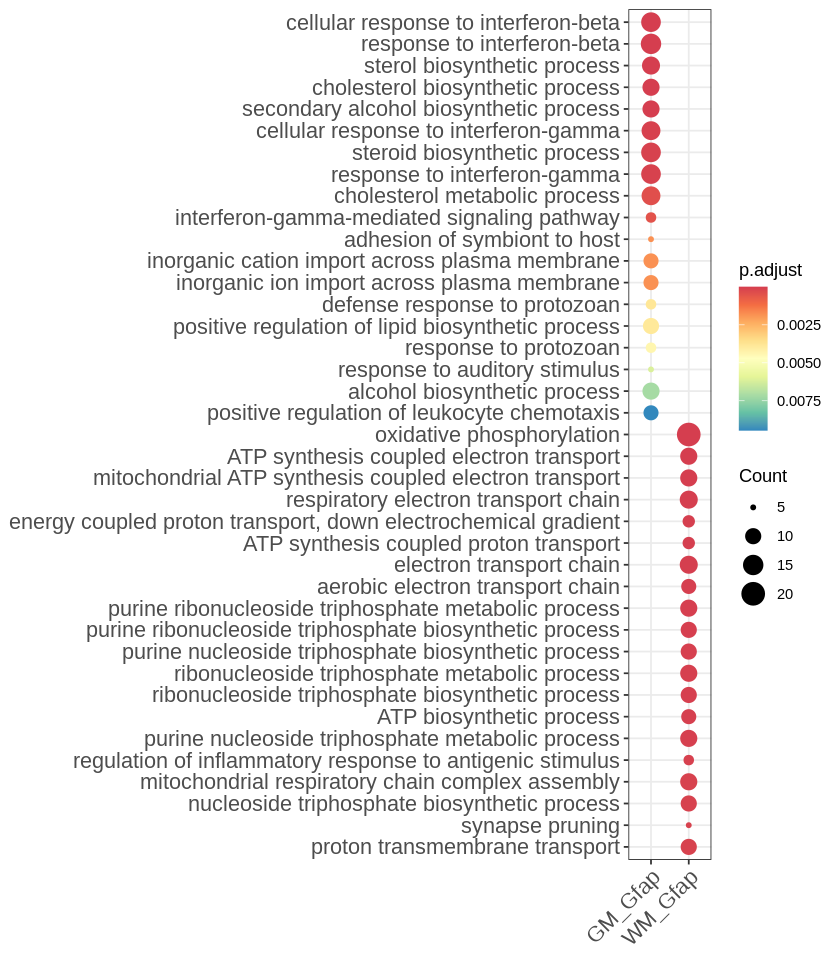

In [465]:
options(repr.plot.width=7, repr.plot.height=8)
library(ggplot2)
p=ggplot(df1,aes(Cluster,Description))+geom_point(aes(size=Count,color=p.adjust))+        #基因数目表示SIZE，p.adjust代表颜色深浅
    scale_color_gradientn(colors=brewer.pal(9,"Spectral"),guide = guide_colorbar(reverse = T))+
    theme_bw()+
    theme(axis.title = element_blank(),axis.text.y.left = element_text(size=13),
          axis.text.x.bottom = element_text(size = 13,angle = 45,hjust = 1,vjust = 1))
p
#ggsave("GM_Gfap.vs.WM_Gfap.fc05.pad001.DEG.pqval001.max150.go.C5.pad_top10.point.png",width = 7,height = 5.5,dpi = 300)


In [ ]:
#GM_Gfap vs. GM_Slc7a10
deg2<-FindMarkers(da1,logfc.threshold = 0.5,ident.1="GM_Gfap",ident.2="GM_Slc7a10")
deg2<-subset(deg2,p_val_adj<0.01)
dim(deg2)
table(deg2$avg_log2FC>0)

In [325]:
deg2$gene<-rownames(deg2)

In [ ]:
deg2$group<-ifelse(deg2$avg_log2FC>0,"GM_Gfap","GM_Slc7a10")
deg2$group<-factor(deg2$group,levels = c("GM_Gfap","GM_Slc7a10"))
deg2<-deg2[order(deg2$group),]
deg2<-deg2[order(deg2$avg_log2FC,decreasing = TRUE),]
head(deg2)

In [360]:
write.csv(deg2,"GM_Gfap.vs.GM_Slc7a10.fc05.pad001.DEG.csv")

In [ ]:
deg2<-read.csv("GM_Gfap.vs.GM_Slc7a10.fc05.pad001.DEG.csv")
rownames(deg2)<-deg2[,1]
deg2<-deg2[,-1]
head(deg2)

In [ ]:
library(org.Mm.eg.db)
library(ggplot2)
#grlabs<-split(gene.nodle.df$gene,gene.nodle.df$module)
grlabs<-split(deg2$gene,deg2$group)
gcSample = lapply(grlabs, function(gr) as.numeric(bitr(gr, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Mm.eg.db")$ENTREZID))
pvalueCutoff = 0.01
qvalueCutoff = 0.01
xx.mus.go2 <- compareCluster(gcSample, OrgDb='org.Mm.eg.db', fun='enrichGO', 
                            pvalueCutoff = pvalueCutoff, qvalueCutoff = qvalueCutoff, ont = "BP", 
                            readable=T,universe=backgenes,maxGSSize=150
                           )
#EnrichResGO_mm = xx.mus.go@compareClusterResult
#options(repr.plot.width=23,repr.plot.height=22)
#                  dotplot(xx.mus.go, title = paste0("Mouse Gene Ontology (qval < ", qvalueCutoff, ")"))
#saveRDS(xx.mus.go,"pc20.k50.res02.cluster_fc025.pct025.pos.markergene_pqv001.max100.go_220524.rds")

In [333]:
saveRDS(xx.mus.go2,"GM_Gfap.vs.GM_Slc7a10.fc05.pad001.DEG.pqval001.max150.go.rds")

In [ ]:
df<-xx.mus.go2@compareClusterResult
head(df)
dim(df)
unique(df$Cluster)
library(dplyr)

In [17]:
deg1_p<-rownames(deg1)[deg1$avg_log2FC>0]
deg1_n<-rownames(deg1)[deg1$avg_log2FC<0]

deg2_p<-rownames(deg2)[deg2$avg_log2FC>0]
deg2_n<-rownames(deg2)[deg2$avg_log2FC<0]

In [ ]:
deg_dp<-intersect(deg1_p,deg2_p)
deg_dp
write.table(deg_dp,"hclust.GM_Gfap.specific.marker.fc05.pad001.txt")

In [ ]:
deg_dp<-read.table("hclust.GM_Gfap.specific.marker.fc05.pad001.txt")
deg_dp<-deg_dp$x
head(deg_dp)
length(deg_dp)

In [ ]:
### WM_GFap vs. GM_Slc7a10
deg3<-FindMarkers(da1,logfc.threshold = 0.5,ident.1="WM_Gfap",ident.2="GM_Slc7a10")
deg3<-subset(deg3,p_val_adj<0.01)
dim(deg3)
table(deg3$avg_log2FC>0)

In [22]:
deg3$gene<-rownames(deg3)

In [ ]:
deg3$group<-ifelse(deg3$avg_log2FC>0,"WM_Gfap","GM_Slc7a10")
deg3$group<-factor(deg3$group,levels = c("WM_Gfap","GM_Slc7a10"))
deg3<-deg3[order(deg3$group),]
deg3<-deg3[order(deg3$avg_log2FC,decreasing = TRUE),]
head(deg3)

In [24]:
deg3_p<-rownames(deg3)[deg3$avg_log2FC>0]
deg3_n<-rownames(deg3)[deg3$avg_log2FC<0]

In [ ]:
sf_gene<-read_excel("/home/jovyan/zxli_SCI/result/Seurat/sc_Astrocyte_recluster/lee/S2_File.xlsx",sheet = "Table B")
head(sf_gene)

In [ ]:
dim(sf_gene)
table(sf_gene$organism)
table(sf_gene$`UniProt cell surface`)
range(sf_gene$`protein probability`)
table(sf_gene$`protein probability`>0.95)

In [ ]:
# dp state surface markers
cand_sg<-intersect(deg_dp,sf_gene$`ENTREZ gene symbol`)
cand_sg

In [ ]:
pdf("Astr_GMii.bothpositive.surface.genes.Vlnplot.220818.pdf",width = 8,height = 8)
options(repr.plot.width=8,repr.plot.height=8)
VlnPlot(da1,features = cand_sg,ncol = 5,
        cols = c('#911eb4',"#ff7b25","#e6beff"),
        #slot = "scale.data",
        pt.size = 0)
dev.off()

In [ ]:
# WM_Gfap surface markers
deg_wm<-intersect(deg1_n,deg3_p)
deg_wm
cand_sg2<-intersect(deg_wm,sf_gene$`ENTREZ gene symbol`)
cand_sg2

In [ ]:
options(repr.plot.width=8,repr.plot.height=6)
VlnPlot(da1,features = cand_sg2,ncol = 5,
        cols = c('#911eb4',"#ff7b25","#e6beff"),
        #slot = "scale.data",
        pt.size = 0)

In [ ]:
# GM_Slc7a10 surface markers
deg_gm<-intersect(deg2_n,deg3_n)
deg_gm
cand_sg3<-intersect(deg_gm,sf_gene$`ENTREZ gene symbol`)
cand_sg3

In [ ]:
dp_wm_deg<-intersect(union(deg3_p,deg1_n),union(deg1_p,deg2_p))
length(dp_wm_deg)
dp_gm_deg<-intersect(union(deg3_n,deg2_n),union(deg1_p,deg2_p))
length(dp_gm_deg)
wm_gm_deg<-intersect(union(deg3_p,deg1_n),union(deg3_n,deg2_n))
length(wm_gm_deg)

In [ ]:
alldeg<-rbind(deg1,deg2,deg3)
alldeg$group<-as.character(alldeg$group)
head(alldeg)
alldeg[alldeg$gene %in% union(deg1_p,deg2_p),"group"]<-"GM_Gfap.specific"
alldeg[alldeg$gene %in% union(deg3_p,deg1_n),"group"]<-"WM_Gfap.specific"
alldeg[alldeg$gene %in% union(deg3_n,deg2_n),"group"]<-"GM_Slc7a10.specific"
alldeg[alldeg$gene %in% dp_wm_deg,"group"]<-"GM_Gfap.WM_Gfap"
alldeg[alldeg$gene %in% dp_gm_deg,"group"]<-"GM_Gfap.GM_Slc7a10"
table(alldeg$group)

In [ ]:
alldeg<-alldeg[!duplicated(alldeg$gene),]
table(alldeg$group)

In [173]:
alldeg$group<-factor(alldeg$group,levels = c("WM_Gfap.specific","GM_Gfap.WM_Gfap",
                                             "GM_Slc7a10.specific",
                                             "GM_Gfap.GM_Slc7a10","GM_Gfap.specific"))


In [ ]:
alldeg<-alldeg[order(alldeg$group,decreasing = FALSE),]
head(alldeg)

In [175]:
write.csv(alldeg,"3state.alldeg.5groups.csv")

In [ ]:
alldeg<-read.csv("3state.alldeg.5groups.csv")
head(alldeg)

#### Astr-GMi and Astr-WM feature score in spatial -220729

In [3]:
da<-readRDS("/home/jovyan/zxli_SCI/result/Seurat/reg.CC/WT_replace_v2/res02_220310/WT.merge.replace_v2.SCT.regress_CC.nC.mt.ident.pc20.k50.res02.rds")

In [ ]:
for(i in unique(deg$cluster)){
    da<-AddModuleScore(da,features = list(deg[deg$cluster==i,"gene"]),name = i)
}

In [ ]:
names<-colnames(da@meta.data)[50:ncol(da@meta.data)]
names

In [31]:
for(i in names){
    options(repr.plot.width=20,repr.plot.height=16)
    ggplot(da@meta.data,aes(x.ad,y.ad))+geom_point(size=1.6,shape=21,stroke=0.15,aes_string(fill= i))+
        #scale_fill_gradientn(colours = colorRampPalette(rev(brewer.pal(n = 7,name = "Spectral")))(50))+
        scale_fill_gradientn(colours = c('#034f84','#92a8d1',#'#b8a9c9', 
        
            '#d6d4e0',#"#deeaee",
        #"#f0f0f0",
        #'#fff2df',
           
            #"#eeac99",
            '#f4a688',
            "#ED797B",                             
            #"#f7786b",                             
            
            "#d64161",
            "#c94c4c"#,
            #"#c83349"
                                        ))+
        xlab(paste0("")) +
        ylab(paste0("")) + 
        theme(panel.background = element_blank(),
              panel.grid.major =element_blank(), 
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),#element_text(size = 15,colour = "black"),
              axis.text.y = element_blank()#element_text(size = 20,colour = "black")
              # axis.ticks.x = element_blank(),
        )
    ggsave(paste0("WT.merge.regress_CC.nC.mt.ident_FindAllMarker.fc025.pos.",i,".spatial_manually_220804.png"),width=20,height=16,dpi=400)
}

##### astrocyte 317 marker module 1,3 score -221009

In [8]:
da<-AddModuleScore(da,features = list(c1),name = "astr_marker_module1_score")
da<-AddModuleScore(da,features = list(c3),name = "astr_marker_module3_score")

In [6]:
da<-AddModuleScore(da,features = list(c(c1,c3)),name = "astr_marker_module13_score")

In [12]:
da$Gfap<-da@assays$SCT@data["Gfap",]
da$Pla2g7<-da@assays$SCT@data["Pla2g7",]
da$Slc7a10<-da@assays$SCT@data["Slc7a10",]
da$Igfbp2<-da@assays$SCT@data["Igfbp2",]

In [ ]:
options(repr.plot.width=20,repr.plot.height=16)
    ggplot(da@meta.data,aes(x.ad,y.ad))+geom_point(size=1.6,shape=21,stroke=0.15,aes_string(fill= "astr_marker_module1_score1"))+
        #scale_fill_gradientn(colours = colorRampPalette(rev(brewer.pal(n = 7,name = "Spectral")))(50))+
        scale_fill_gradientn(colours = c('#034f84','#92a8d1',#'#b8a9c9', 
        
            '#d6d4e0',#"#deeaee",
        #"#f0f0f0",
        #'#fff2df',
           
            #"#eeac99",
            '#f4a688',
            "#ED797B",                             
            #"#f7786b",                             
            
            "#d64161",
            "#c94c4c"#,
            #"#c83349"
                                        ))+
        xlab(paste0("")) +
        ylab(paste0("")) + 
        theme(panel.background = element_blank(),
              panel.grid.major =element_blank(), 
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),#element_text(size = 15,colour = "black"),
              axis.text.y = element_blank()#element_text(size = 20,colour = "black")
              # axis.ticks.x = element_blank(),
        )
    #ggsave(paste0("WT.merge.regress_CC.nC.mt.ident_FindAllMarker.fc025.pos.",i,".spatial_manually_220804.png"),width=20,height=16,dpi=400)

In [ ]:
options(repr.plot.width=20,repr.plot.height=16)
    ggplot(da@meta.data,aes(x.ad,y.ad))+geom_point(size=1.6,shape=21,stroke=0.15,aes_string(fill= "astr_marker_module3_score1"))+
        #scale_fill_gradientn(colours = colorRampPalette(rev(brewer.pal(n = 7,name = "Spectral")))(50))+
        scale_fill_gradientn(colours = c('#034f84','#92a8d1',#'#b8a9c9', 
        
            '#d6d4e0',#"#deeaee",
        #"#f0f0f0",
        #'#fff2df',
           
            #"#eeac99",
            '#f4a688',
            "#ED797B",                             
            #"#f7786b",                             
            
            "#d64161",
            "#c94c4c"#,
            #"#c83349"
                                        ))+
        xlab(paste0("")) +
        ylab(paste0("")) + 
        theme(panel.background = element_blank(),
              panel.grid.major =element_blank(), 
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),#element_text(size = 15,colour = "black"),
              axis.text.y = element_blank()#element_text(size = 20,colour = "black")
              # axis.ticks.x = element_blank(),
        )
    #ggsave(paste0("WT.merge.regress_CC.nC.mt.ident_FindAllMarker.fc025.pos.",i,".spatial_manually_220804.png"),width=20,height=16,dpi=400)

In [ ]:
options(repr.plot.width=20,repr.plot.height=16)
    ggplot(da@meta.data,aes(x.ad,y.ad))+geom_point(size=1.6,shape=21,stroke=0.15,aes_string(fill= "astr_marker_module13_score1"))+
        #scale_fill_gradientn(colours = colorRampPalette(rev(brewer.pal(n = 7,name = "Spectral")))(50))+
        scale_fill_gradientn(colours = c('#034f84','#92a8d1',#'#b8a9c9', 
        
            '#d6d4e0',#"#deeaee",
        #"#f0f0f0",
        #'#fff2df',
           
            #"#eeac99",
            '#f4a688',
            "#ED797B",                             
            #"#f7786b",                             
            
            "#d64161",
            "#c94c4c"#,
            #"#c83349"
                                        ))+
        xlab(paste0("")) +
        ylab(paste0("")) + 
        theme(panel.background = element_blank(),
              panel.grid.major =element_blank(), 
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),#element_text(size = 15,colour = "black"),
              axis.text.y = element_blank()#element_text(size = 20,colour = "black")
              # axis.ticks.x = element_blank(),
        )
    ggsave("WT.SA14_score.spatial_manually_221008.png",width=20,height=16,dpi=400)


In [176]:
pdf("WT.4domain.spatial_manually_221011.pdf",width=20,height=16)
options(repr.plot.width=20,repr.plot.height=16)
    ggplot(da@meta.data,aes(x.ad,y.ad))+geom_point(size=1.6,shape=21,stroke=0.15,aes_string(fill= "domain_res02"))+
        #scale_fill_gradientn(colours = colorRampPalette(rev(brewer.pal(n = 7,name = "Spectral")))(50))+
        scale_fill_manual(values = c('#BC3C29A8','#0072B5A8','#E18727A8','#20854EA8'))+
        xlab(paste0("")) +
        ylab(paste0("")) + 
        theme(panel.background = element_blank(),
              panel.grid.major =element_blank(), 
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),#element_text(size = 15,colour = "black"),
              axis.text.y = element_blank()#element_text(size = 20,colour = "black")
              # axis.ticks.x = element_blank(),
        )
#ggsave("WT.4domain.spatial_manually_221011.png",width=20,height=16,dpi=400)
dev.off()

png 
  2

In [ ]:
da$domain_2<-ifelse(da$domain_res02=="WM","WM","GM")
unique(da$domain_2)

In [ ]:
pdf("WT.2domain.spatial_manually_221011.pdf",width=20,height=16)
options(repr.plot.width=20,repr.plot.height=16)
    ggplot(da@meta.data,aes(x.ad,y.ad))+geom_point(size=1.6,shape=21,stroke=0.05,aes_string(fill= "domain_2"))+
        #scale_fill_gradientn(colours = colorRampPalette(rev(brewer.pal(n = 7,name = "Spectral")))(50))+
        scale_fill_manual(values = c(#'#BC3C29A8',
            '#ada397',
            #'#E18727A8',
            #'#36486b',
                                     '#deeaee'
                                    ))+
        xlab(paste0("")) +
        ylab(paste0("")) + 
        theme(panel.background = element_blank(),
              panel.grid.major =element_blank(), 
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),#element_text(size = 15,colour = "black"),
              axis.text.y = element_blank()#element_text(size = 20,colour = "black")
              # axis.ticks.x = element_blank(),
        )
dev.off()

#### neuron loss, SA_score, injury_score -221010

In [8]:
injury_genes<-c('Adamts1','Atf3','Ccl2','Ccnd1','Cd68','Cebpd','Cyba',
                'Fn1','Gal','Gap43','Hmox1','Hspb1','Igfbp2','Jun','Junb',
                'Fos','Lgals1','Neat1','Socs3','Tnc','S100a10','Timp1')
da<-AddModuleScore(da,features = list(injury_genes),name = "injury_score")

In [13]:
me<-da@meta.data

In [ ]:
neuron<-read.csv("/home/jovyan/zxli_SCI/result/RCTD/testC5/WT_all/fcreg1_220503/fcreg1_220724/15celltypes.dec_conf_nor.meta.csv")
rownames(neuron)<-neuron[,1]
neuron<-neuron[,-1]
head(neuron)

In [ ]:
meta<-cbind(me[,c('orig.ident','distance',"time","RC","pos","domain_res02","x.ad","y.ad","injury_score1",
                  "astr_marker_module13_score1","Gfap","Slc7a10","Pla2g7","Igfbp2")],neuron[,"Neuron"])
head(meta)

In [ ]:
colnames(meta)[ncol(meta)]<-"Neuron"
head(meta)

In [16]:
write.csv(meta,"Neuronloss_SAscore_Injuryscore.meta.csv")

In [ ]:
meta<-read.csv("Neuronloss_SAscore_Injuryscore.meta.csv")
meta$pos<-factor(meta$pos,levels = unique(meta$pos))
rownames(meta)<-meta[,1]
meta<-meta[,-1]
head(meta)

In [4]:
#subset 24hpi and 72hpi
meta_sub<-meta[meta$time %in% c('WT_24h','WT_72h'),]

In [ ]:
#meta_sub<-meta_sub[order(meta_sub$Neuron,decreasing = TRUE),]
meta_sub<-meta_sub[order(meta_sub$pos,decreasing = TRUE),]
head(meta_sub)

In [ ]:
me3<-meta_sub[meta_sub$time=="WT_72h",]
cor(me3[,c("injury_score1","astr_marker_module13_score1",'Gfap','Slc7a10','Igfbp2','Neuron')],method = "spearman")

In [ ]:
me4<-me3[me3$domain_res02 %in% c("MG","DH","VH"),]
me4$dis2<-ifelse(me4$distance=="1mm",1,0.5)
unique(me4$dis2)
cor(me4[,c("injury_score1","astr_marker_module13_score1",'Gfap','Slc7a10','Igfbp2','Neuron')],method = "spearman")

In [ ]:
cor.test(me4[,c("injury_score1")],me4[,c('Neuron')],method = "spearman")

In [ ]:
cor.test(me4[,c("astr_marker_module13_score1")],me4[,c('Neuron')],method = "spearman")

In [ ]:
cor.test(me4[,c("dis2")],me4[,c('Neuron')],method = "spearman")

In [ ]:
cor.test(me4[,c("astr_marker_module13_score1")],me4[,c("injury_score1")],method = "spearman")

In [ ]:
cor.test(me4[,c("dis2")],me4[,c('injury_score1')],method = "spearman")

In [145]:
spc<-cor(me4[,c("injury_score1","astr_marker_module13_score1",'Neuron',"dis2")],method = "spearman")

In [ ]:
spc<-melt(spc)
head(spc)

In [9]:
# z-score
me4$injury_score1<-(me4$injury_score1-min(me4$injury_score1))/(max(me4$injury_score1)-min(me4$injury_score1))
me4$astr_marker_module13_score1<-(me4$astr_marker_module13_score1-min(me4$astr_marker_module13_score1))/(max(me4$astr_marker_module13_score1)-min(me4$astr_marker_module13_score1))


In [ ]:
me4$spot<-seq(1,nrow(me4))
head(me4)

In [ ]:
temp<-melt(me4[,c("spot","Neuron",#"injury_score1",
                  "astr_marker_module13_score1","pos")],
           id.vars = c("spot","pos"),variable.name = "group")
head(temp)

In [ ]:
pdf("Neuronloss_SAscore.loessfitting.72h.GM.position_221024.pdf",height = 5,width = 9)
options(repr.plot.width=9,repr.plot.height=5)
ggplot(temp, aes(x = spot, y = value,color=group)) +
    geom_point(size=0.01) +
    scale_color_manual(values = c('#034f84',
                                  #'#5D3B83',
                                  '#C580AA',
                                  '#316B9B'#,'#E2E293'
                                 ))+
    stat_smooth(method = "loess",se=FALSE,size=2#,
        #col = "#C42126",
        #se = FALSE,
        #size = 1
               )+
    theme_classic()
dev.off()

In [ ]:
temp<-melt(me4[,c("spot","Neuron","injury_score1","astr_marker_module13_score1")],
           id.vars = c("spot"),variable.name = "group")
head(temp)

#### correlate to other studies

In [ ]:
library(clusterProfiler)

In [204]:
### proflammatory-factor
infm<-c("Angpt2","Tek","Ccl2","Ackr1","Cd34","Sell","Cd44","Sele","Csf1","Csf1r","Glg1","Selplg",
        "Tnfsf10","Tnfrsf10b","Alox5ap","Alox5","C3","C3ar1","Ccl5","Esam","C3ar1","Ccr1",
        "Hebp1","Lgals9","Havcr2")

In [ ]:
alldeg[alldeg$gene %in% infm,]
infm_s<-infm[infm %in% alldeg$gene]
infm_s

In [202]:
### anti-infalmmatory genes
anti_inf<-c("Sirpa","Tyro3","Cx3cl1","Cx3cr1","Il6","Gas6","Anxa1","Pros1","Pomc",
            "Tgfb2","Il6r","Il6st","Tyro3","Mc1r","Jag1","Grn","Cd47",
            "Cd46","Mc1r","Axl","Tgfbr1","Tgfbr2",
            "Itgax","Itgb2","Fpr1","Tnfrsf1b","Tnfrsf11b")

In [ ]:
anti_c<-alldeg[alldeg$gene %in% anti_inf,"gene"]
anti_c

In [208]:
### trophic factors
tr_f<-c("Bmp","Bmpr1b","Bmpr2","Enho","Gpr19","Fgf1","Fgfr3","Fgf9","Nectin1","Psap","Bmp4",
                         "Gpr37l1","Flt1","Vegfa","Nrp1","Nrp2","Fgf7","Fgfr1","Gdf11","Tgfbr1",
                         "Acvr2b","Hgf","Met","Pdgfb","Pdgfra","Pdgfc","Pdgfd","Rspo3","Lgr5","Wnt2","Pdgfrb",
                         "Fzd4","Wnt5a","Fzd1","Fzd5")

In [ ]:
alldeg[alldeg$gene %in% tr_f,]
tr_f_s<-tr_f[tr_f %in% alldeg$gene]
tr_f_s

In [ ]:
prot_c<-c("Csf1","Pros1",tr_f_s)
prot_c

In [ ]:
cand_df<-alldeg[alldeg$gene %in% c(#pig,
                                   anti_c,tr_f_s,infm_s),]
cand_df$label<-""
#cand_df$label[cand_df$gene %in% pig]<-"PIGs"
cand_df$label[cand_df$gene %in% anti_c]<-"Anti-inflammatory"
cand_df$label[cand_df$gene %in% tr_f_s]<-"Trophic.factor"
cand_df$label[cand_df$gene %in% infm_s]<-"Pro-inflammatory"
table(cand_df$label)

In [ ]:
cand_df$protective<-ifelse(cand_df$gene %in% prot_c,"y","n")
table(cand_df$protective)

In [ ]:
# add state bulk normalized expression
bulk_exp<-as.matrix(da1@assays$SCT@data[cand_df$gene,])
df<-as.data.frame(t(bulk_exp))
df$state<-as.character(da1$state)
df_mean<-aggregate(df[,colnames(df)!="state"],list(df$state),mean)
head(df_mean)

In [ ]:
rownames(df_mean)<-df_mean[,1]
df_mean<-scale(df_mean[,-1])
head(df_mean)

In [ ]:
table(cand_df$gene==colnames(df_mean))
cand_df<-cbind(cand_df,t(df_mean))
head(cand_df)

In [ ]:
df1<-cand_df[,c("gene","group","label","protective","GM_Gfap","GM_Slc7a10","WM_Gfap")]
df1_l<-melt(df1)
head(df1_l)

In [220]:
df1_l$label<-factor(df1_l$label,levels = c('Trophic.factor','Anti-inflammatory','Pro-inflammatory'#,'PIGs'
                                          ))
df1_l<-df1_l[order(df1_l$label),]

In [223]:
write.csv(df1_l,"associate.gene_spatial.state.average.expression.df_220630.csv")

In [ ]:
df1_l<-read.csv("associate.gene_spatial.state.average.expression.df.csv")
head(df1_l)

In [ ]:
temp<-df1_l[grep("GM_Gfap",df1_l$group),]
temp$gene<-factor(temp$gene,levels = rev(unique(temp$gene)))
dim(temp)

In [ ]:
alldeg[alldeg$gene %in% c("Csf1","Cx3cl1","Cx3cr1","Il6",
                          "Gas6","Anxa1","Pros1","Pomc",
                          "Tgfbr2","Tgfb2","Tyro3","Tnfrsf1b",
                         "Mc1r","Jag1","Axl","Vegfa","Hgf","Psap",
                         "Fgf1","Met","Gdf11","Wnt2","Pdgfrb","Nrp2"),]

In [ ]:
alldeg[alldeg$gene %in% c("Bmpr2","Wnt5a","Nrp1","Cd47","Sirpa","Fpr1","Il6r","Ccl2",
                          "C3","Cd44","Csf1r","Ccl5","Alox5","Ccr1","Tnfsf10","Alox5ap",
                         "Selplg"),
      ]

In [ ]:
options(repr.plot.width=8,repr.plot.height=13)
VlnPlot(da1,features = cand_sg3,ncol = 5,
        cols = c('#911eb4',"#ff7b25","#e6beff"),
        #slot = "scale.data",
        pt.size = 0)

In [ ]:
deg<-rbind(deg1,deg2)
dim(deg)
head(deg)                

In [ ]:
unique(deg$group)
deg$group<-factor(deg$group,levels = c("GM_Gfap","WM_Gfap","GM_Slc7a10"))
deg<-deg[order(deg$group),]
table(deg$group)

In [83]:
# deg_dp score
da1<-AddModuleScore(da1,features = list(deg_dp),name = "deg_dp_score")

#### bulk heatmap of all deg across 3 spatial state

In [ ]:
bulk_exp<-as.matrix(da1@assays$SCT@data[alldeg$gene,])
#bulk_exp<-t(scale(t(bulk_exp)))
dim(bulk_exp)

In [ ]:
head(bulk_exp)
df<-as.data.frame(t(bulk_exp))
df$state<-as.character(da1$state)
df_mean<-aggregate(df[,colnames(df)!="state"],list(df$state),mean)
head(df_mean)

In [ ]:
rownames(df_mean)<-df_mean[,1]
df_mean<-df_mean[,-1]
df_mean<-df_mean[c(3,2,1),]
head(df_mean)
#row_col<-data.frame(row.names = colnames(df_mean))
#row_col$color<-"grey"
#row_col[p_genes,"color"]<-"#ff7b25"#"#911eb4"
##row_col[intersect(g2,rownames(row_col)),"color"]<-"#e6beff"
#table(row_col$color)

In [16]:
write.csv(df_mean,"3states.5groups.deg.bulk.data.csv")

In [ ]:
df_mean<-read.csv("3states.5groups.deg.bulk.data.csv")
rownames(df_mean)<-df_mean[,1]
df_mean<-df_mean[,-1]
head(df_mean)

In [ ]:
col_ha<-as.data.frame(alldeg$group)
colnames(col_ha)<-"group"
rownames(col_ha)<-alldeg$gene
#rownames(col_ha)<-spatial_marker$gene
#col_ha$group<-ifelse(col_ha$group=="WM_Gfap","#911eb4","#e6beff")
table(col_ha$group)
head(col_ha)
dim(col_ha)

In [ ]:
## go term
library(org.Mm.eg.db)
library(ggplot2)
#grlabs<-split(gene.nodle.df$gene,gene.nodle.df$module)
grlabs<-split(alldeg$gene,alldeg$group)
gcSample = lapply(grlabs, function(gr) as.numeric(bitr(gr, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Mm.eg.db")$ENTREZID))
pvalueCutoff = 0.05
qvalueCutoff = 0.05
xx.mus.go <- compareCluster(gcSample, OrgDb='org.Mm.eg.db', fun='enrichGO', 
                            pvalueCutoff = pvalueCutoff, qvalueCutoff = qvalueCutoff, ont = "BP", 
                            readable=T,universe=backgenes,maxGSSize=1000
                           )
#EnrichResGO_mm = xx.mus.go@compareClusterResult
#options(repr.plot.width=23,repr.plot.height=22)
#                  dotplot(xx.mus.go, title = paste0("Mouse Gene Ontology (qval < ", qvalueCutoff, ")"))
#saveRDS(xx.mus.go,"pc20.k50.res02.cluster_fc025.pct025.pos.markergene_pqv001.max100.go_220524.rds")


In [20]:
saveRDS(xx.mus.go,"3state.fc05.pad005.alldeg.5group.pqval001.max1000.go.rds")

In [340]:
xx.mus.go<-readRDS("3state.fc05.pad001.alldeg.5group.pqval001.max150.go.rds")

In [ ]:
df<-xx.mus.go@compareClusterResult
head(df)
dim(df)
unique(df$Cluster)
library(dplyr)

In [30]:
df1 = df %>% group_by(.,Cluster) %>% filter(.,Count>=5) %>% top_n(.,-20,p.adjust)  #按照Cluster排序，并取每个cluster的前20个
df1$Description = factor(df1$Description,levels = rev(unique(df1$Description)))  #对Description进行按cluster排序，后面展示时同一cluster的go可以放在一起                 
                  

In [ ]:
options(repr.plot.width=10, repr.plot.height=18)
library(ggplot2)
p=ggplot(df1,aes(Cluster,Description))+geom_point(aes(size=Count,color=p.adjust))+        #基因数目表示SIZE，p.adjust代表颜色深浅
    scale_color_gradientn(colors=brewer.pal(9,"Spectral"),guide = guide_colorbar(reverse = T))+
    theme_bw()+
    theme(axis.title = element_blank(),axis.text.y.left = element_text(size=13),
          axis.text.x.bottom = element_text(size = 13,angle = 45,hjust = 1,vjust = 1))
p
ggsave("3state.fc05.pad001.alldeg.5group.pqval005.max1000.go.C5.pad_top20.point.png",width = 10,height = 18,dpi = 300)


#### add associated gene into bulk DEG pheatmap

In [228]:
temp<-as.matrix(t(df_mean))

In [ ]:
col_ha<-as.data.frame(alldeg$group)
colnames(col_ha)<-"group"
rownames(col_ha)<-alldeg$gene
#rownames(col_ha)<-spatial_marker$gene
#col_ha$group<-ifelse(col_ha$group=="WM_Gfap","#911eb4","#e6beff")
table(col_ha$group)
head(col_ha)
dim(col_ha)

In [ ]:
row_col<-data.frame(row.names = colnames(df_mean))
row_col$color<-"grey"
row_col[unique(df1_l$gene),"color"]<-"#ff7b25"#"#911eb4"
#row_col[intersect(g2,rownames(row_col)),"color"]<-"#e6beff"
table(row_col$color)

In [231]:
group<-c('#ff7b25','#eea29a','#911eb4','#d5f4e6','#e6beff')
names(group)<-c("GM_Gfap.specific","GM_Gfap.WM_Gfap","WM_Gfap.specific","GM_Gfap.GM_Slc7a10","GM_Slc7a10.specific")
#time
#state
#group
#unique(da1$time)
#unique(da1$state)
an_col<-list(group=group)

In [ ]:
options(repr.plot.width=6,repr.plot.height=12)
p<-pheatmap::pheatmap(temp,show_rownames = T,show_colnames = T,
                      annotation_colors = an_col,
                       annotation_row = col_ha,
                      cluster_cols = F,
                      cluster_rows = F,scale = "row",
                      clustering_distance_rows = "euclidean",
                      clustering_method = "average",#labels_row = lab_row,
                   cellwidth = 20,
                   cellheight = 0.5,
                   fontsize = 8,
                   #na_col = NULL,
                   border_color = NA
                   #,scale = "none",col = viridis_pal()(50)
       )
cols<-row_col[order(match(rownames(temp),p$gtable$grobs[[5]]$label)),]
p$gtable$grobs[[5]]$gp=gpar(col=cols)
add.flag(p,kept.labels = unique(df1_l$gene),repel.degree = 1)

In [ ]:
pdf("3state.alldeg.5groups.fc05.pad001.marker.bulk.data.mean.scale_associategenes.heatmap_220630.pdf",width = 5,height = 10)
add.flag(p,kept.labels = unique(df1_l$gene),repel.degree = 1)
dev.off()
#save_pheatmap_pdf(p,"3state.alldeg.5groups.fc05.pad001.marker.bulk.data.mean.scale_associategenes.heatmap.pdf",width = 5,height = 12)